<a href="https://colab.research.google.com/github/AlexandraVallet/fenicslectures/blob/main/DiffusionBrainSleep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion of tracer in the brain

The purpose of this notebook is to learn how to solve the diffusion equation using the finite element computing tool FEniCS. Then we propose to apply this knowledge to interpret clinical data of transport and clearance of tracer in human brain.

# I/ Sleep deprivation effect on tracer transport and clearance in the human brain

By the end of this notebook, we will perform simulations of tracer diffusion in the brain to interpret data from this paper :

Sleep deprivation impairs molecular clearance from the human brain,
Per Kristian Eide, Vegard Vinje, Are Hugo Pripp, Kent-Andre Mardal, Geir Ringstad,
Brain, Volume 144, Issue 3, March 2021, Pages 863–874, https://doi.org/10.1093/brain/awaa443

![image.png](https://github.com/AlexandraVallet/fenicslectures/blob/main/images/brain_enrichment.png?raw=1)


Abstract : "It remains an enigma why human beings spend one-third of their life asleep. Experimental data suggest that sleep is required for
clearance of waste products from brain metabolism. This has, however, never been verified in humans. The primary aim of the pre-
sent study was to examine in vivo whether one night of total sleep deprivation affects molecular clearance from the human brain.
Secondarily, we examined whether clearance was affected by subsequent sleep. Multiphase MRI with standardized T1 sequences
was performed up to 48 h after intrathecal administration of the contrast agent gadobutrol (0.5 ml of 1 mmol/ml), which served as
a tracer molecule. Using FreeSurfer software, we quantified tracer enrichment within 85 brain regions as percentage change from
baseline of normalized T1 signals. The cerebral tracer enrichment was compared between two cohorts of individuals; one cohort
(n = 7) underwent total sleep deprivation from Day 1 to Day 2 (sleep deprivation group) while an age and gender-matched control
group (n = 17; sleep group) was allowed free sleep from Day 1 to Day 2. From Day 2 to 3 all individuals were allowed free sleep.
The tracer enriched the brains of the two groups similarly. Sleep deprivation was the sole intervention. One night of sleep depriv-
ation impaired clearance of the tracer substance from most brain regions, including the cerebral cortex, white matter and limbic
structures, as demonstrated on the morning of Day 2 after intervention (sleep deprivation/sleep). Moreover, the impaired cerebral
clearance in the sleep deprivation group was not compensated by subsequent sleep from Day 2 to 3. The present results provide
in vivo evidence that one night of total sleep deprivation impairs molecular clearance from the human brain, and that humans do
not catch up on lost sleep. "


# II/  Diffusion equation 

We consider the diffusion of the concentration c of a chemical solute (here the Gadobustrol tracer), as a function of the position x. 
Experimentally it is known that the flux of this quantity, ie. the amount of the quantify crossing a unit area per time, is given by the relation
$$ F = - k \nabla c $$ with k the coefficient of diffusion. 
We note hee the minus sign, as the diffusion flux is directed toward the regions of lower concentration. 

## Time dependant equation

The diffusion equation for the concentration is given by 
$$\frac{\partial c}{\partial t}= - k \Delta c + S(x) $$
where $S(x)$ is a source term.

## Steady state

In the case of a steady problem, we obtain a Laplace problem : 

\begin{alignat}{2}
-\Delta c &= f \quad && \text{ in } \Omega \\
u &= u_{\mathrm{D}} \quad && \text{ on } \Gamma_{\mathrm{D}} \\
\partial_n u &= g \quad && \text{ on } \Gamma_{\mathrm{N}}
\end{alignat}

with $f=S(x)/k$, $u_{\mathrm{D}}$ a Dirichlet boundary condition and $ g$ a Neumann boundary condition.

Let's try to resolve this equation using FEniCS !


# III/ Solve the steady problem with FEniCS 

For hints and more reading on how to solve the Poisson problem in FEniCS, see the [section on the Poisson problem](https://fenicsproject.org/pub/tutorial/html/._ftut1004.html#ch:fundamentals) in the [FEniCS Tutorial](https://fenicsproject.org/tutorial/).

## Creating the computing environment

### Importing FEniCS
The first thing we need to do is to import `FEniCS` and the meshing library `mshr`.

In [ ]:
# Installing and Importing Fenics
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics



In [ ]:
try:
    import google.colab  # noqa: F401
except ImportError:
    import dolfin
    import mshr
else:
    try:
        import dolfin
        import mshr
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
        import dolfin
        import mshr

### Initializing notebook plotting options


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 

### Importing other libraries



In [ ]:
import numpy as np
from math import sqrt

## Creating the mesh

We are now ready to set up our computing framework. We start with the geometry. Let create a mesh for a square domain with a circular hole in the middle.

To create the mesh, we use boolean operators from `mshr`. 

Define one square and a circle, then combine them with operators :
- `+` (union), 
- `*` (intersection),
- `-` (set difference). 

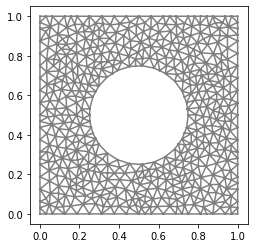

In [ ]:
S0 = mshr.Rectangle(dolfin.Point(0, 0), dolfin.Point(1, 1))
C0 = mshr.Circle(dolfin.Point(0.5,0.5),0.25)
domain = S0-C0
mesh = mshr.generate_mesh(domain,20)
dolfin.plot(mesh)

## Defining the finite element function space
Once the mesh is created, we can define the finite element function space $V$. We will use a standard piecewise linear $P_1$ function space.

In [ ]:
V = dolfin.FunctionSpace(mesh,'P',1)

## Defining the boundary condition
The boundaries can be defined using a condition of distance. 

In [ ]:
def circle(x, on_boundary):
    # distance to the center of the circle
    #x being the coordiate in two dimensions : x[0] and x[1]
    d0 = sqrt((x[0]-0.5)**2 + (x[1]-0.5)**2)
    # The inner boundary is defined to be on the boudary and at a distance smaller that the radius 0.3 
    return on_boundary and (d0 < 0.3)



The outer boundary 


In [ ]:
def outside(x, on_boundary):
    # distance to the center of the circle
    #x being the coordiate in two dimensions : x[0] and x[1]
    d0 = sqrt((x[0]-0.5)**2 + (x[1]-0.5)**2)
    # The outer boundary is defined to be on the boudary and at a distance larger that the radius 0.3
    return on_boundary and (d0 > 0.3)

The Dirichlet boundary condition 

$$ u = u_{\mathrm{D}} \quad  \text{ on } \Gamma_{\mathrm{D}} $$

is defined using the dolfin built in function `DirichletBC`.

We decide to impose c=0 on the inner circle boundary

In [ ]:
bc = dolfin.DirichletBC(V, 0 , circle)

The Neumann boundary condition

$$\partial_n u = g \quad  \text{ on } \Gamma_{\mathrm{N}} $$

will appear directly in the weak form of the equations.

We define an outer flow boundary condition (Neumann) which will be applied on all the boundaries where no Dirichlet condition is defined.


In [ ]:
g=dolfin.Constant(1)

## Defining the variational problem
The finite element variational problem for the Poisson equation reads: 

Find $u \in V$ such that
$$
-\int_{\Omega} (\nabla^2 u)  v \,\mathrm{d}x = \int_{\Omega} fv \,\mathrm{d}x 
$$


We have 
$$
-\int_{\Omega} (\nabla^2 u)  v \,\mathrm{d}x =\int_{\Omega} \nabla u \cdot \nabla v \,\mathrm{d}x - \int_{\partial \Omega} \frac{\partial u}{\partial n} v  \,\mathrm{d}s
$$


By definition of the finite element function space $v=0$ on $\Gamma_D$, thus

$$ - \int_{\partial \Omega} \frac{\partial u}{\partial n} v  \,\mathrm{d}s = - \int_{\partial\Omega} gv \,\mathrm{d}s $$

The resulting weak form of our problem reads

$$
\int_{\Omega} \nabla u \cdot \nabla v \,\mathrm{d}x = \int_{\Omega} fv \,\mathrm{d}x +\int_{\partial\Omega} gv \,\mathrm{d}s
$$
for all $v \in V$.

This can be expressed in FEniCS by defining the *bilinear form* $a$ and the *linear form* $L$:

\begin{align}
  a(u, v) &= \int_{\Omega} \nabla u \cdot \nabla v \,\mathrm{d}x, \\
  L(v) &= \int_{\Omega} fv \,\mathrm{d}x+\int_{\partial\Omega} gv \,\mathrm{d}s.
\end{align}

And the problem is to solve 

$$a(u, v)= L(v)$$ 

We first define the trial and test function using the built in functions

In [ ]:
u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)

Then, we define the source term as a gaussian function

In [ ]:
f = dolfin.Expression('exp(-10.0*(pow(x[0]-0.5,2) + pow(x[1] - 0.5,2)))',degree = 2)

The bilinear form a and the linea form L are defined as follow :

In [ ]:
a = dolfin.inner(dolfin.grad(u), dolfin.grad(v))*dolfin.dx
L = f*v*dolfin.dx + g*v*dolfin.ds

The ds variable implies a boundary integral, while dx implies an integral over the domain Ω.

The integration $ds$ is carried out over the entire boundary, including the Dirichlet boundary. However, since the test function v vanishes on the Dirichlet boundary (as a result specifying a `DirichletBC`), the integral will only include the contribution from the Neumann boundary.

## Solving the variational problem
The variational problem can now be solved by calling the FEniCS `solve` command. 

In [ ]:
c = dolfin.Function(V)
dolfin.solve(a == L, c, bc)


The dolfin `plot` function can be used to visualize the solution. 

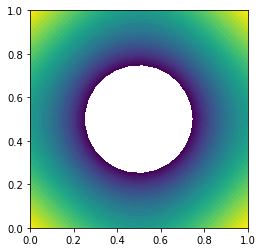

In [ ]:
dolfin.plot(c)

## Postprocessing

We can integrate the value of c over the entire domain using the dolfin function `assemble`

In [ ]:
integral=dolfin.assemble(c*dolfin.dx(mesh))

print('Total mass :',integral)

Total mass : 0.2841729766611889


# IV/ Solve the time dependant problem with FEniCS

We now consider the time dependant problem governed by the diffusion equation 

$$\frac{\partial c}{\partial t}= -k\Delta c + S(x)$$

## Time discretisation 

We discretize the time derivative with a finite difference approximation.


Let superscript $n$ denote a quantity at time $t_n$, where $n$ is an integer counting the time steps of length $\Delta t$. The time derivative can be discretized by

$$ \frac{\partial c}{\partial t}^{n+1}= \frac{c^{n+1}-c^{n}}{\Delta t}$$

Then, using an implicit backward Euler scheme, the diffusion equation at time step $n+1$ is

$$ \frac{c^{n+1}-c^{n}}{\Delta t}=-k\Delta c^{n+1} + S(x)^{n+1}$$

The solution of c at time step $n+1$ is obtained by solving the stationary problem 

$$ c^{n+1}+k\Delta c^{n+1} \Delta t - S(x)^{n+1} \Delta t - c^n =0$$


## Variational form 

Let u be the solution $c^{n+1}$. 



We multiply by a test function v and integrate second-derivatives by parts and use the divergence theorem. This lead to the bilinear and linear forms

\begin{align}
  a(u, v) &= \int_{\Omega} (uv + k\Delta t \nabla u \cdot \nabla v ) \,\mathrm{d}x, \\
  L(v) &= \int_{\Omega}  (S(x)^{n+1} \Delta t + c^{n} ) v  \,\mathrm{d}x+\int_{\partial \Omega} g^{n+1}\Delta t v \,\mathrm{d}s
\end{align}





In [ ]:
# for the exemple we set a time step 
dt=1
# a uniform previous solution at previous time step
u_n=dolfin.interpolate(dolfin.Constant(0),V)
# a uniform source term
S=dolfin.interpolate(dolfin.Constant(0),V)
# a diffusion coefficient
k=1


F = u*v*dolfin.dx + k*dt*dolfin.inner(dolfin.grad(u), dolfin.grad(v))*dolfin.dx - (u_n + dt*S)*v*dolfin.dx + dt*g*v*dolfin.ds
a, L = dolfin.lhs(F), dolfin.rhs(F)

## Initial conditions

Let define the initial conditions. For the example we use a gaussian-like function. 


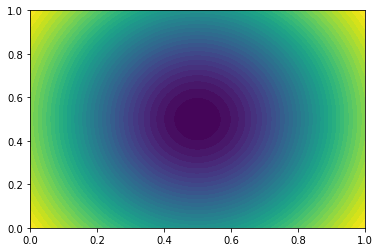

In [ ]:
x=np.linspace(0,1,100) 
y=np.linspace(0,1,100)

X,Y =np.meshgrid(x, y)

x0=0.5 
y0=0.5 
sx=0.5 
sy=0.5
A=10

Z=A-A*np.exp(-((X-x0)**2/(2*sx**2) + (Y - y0)**2)/(2*sy**2))

plt.contourf(X,Y,Z,50)


In the dolfin syntax (similar to C) this function is defined as

In [ ]:
cinit=dolfin.Expression('A-A*exp(-((pow(x[0]-x0,2)/(2*pow(sx,2)))+(pow(x[1]-y0,2)/(2*pow(sy,2)))))', A=10,x0=0.5,y0=0.5,sx=0.5,sy=0.5,degree = 2)

### Source term definition

We set the source term as a homogeneous sink term. 





In [ ]:
S=dolfin.Constant(1)

### Boundary conditions

We decide to change the boundary conditions. This time we impose a concentration c= 0 on the outer boundary and an outflow in the inner boundary. 

In [ ]:
bc = dolfin.DirichletBC(V, 0 , outside)
g=dolfin.Constant(0.1)

### Time stepping definition


In [ ]:
# number of time steps
num_steps=5

# duration of time step
dt=0.05

### Diffusion parameter

For the exemple we use an arbitrary value for the diffusion parameter

In [ ]:
k=0.5

## Resolution 

Finaly we solve the problem over several time steps



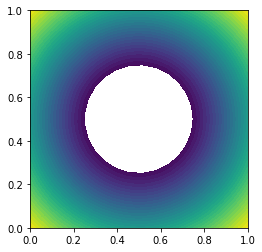

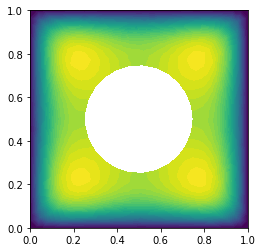

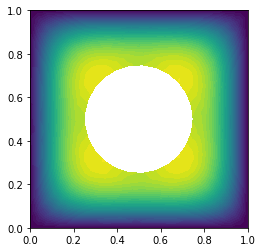

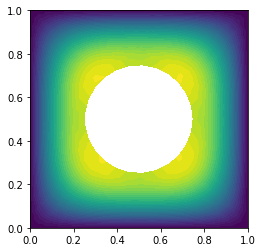

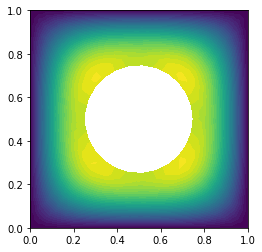

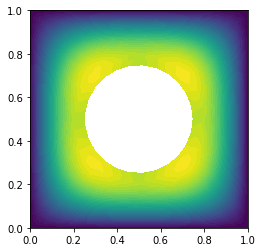

In [ ]:
#initialization
t=0
c_n = dolfin.interpolate(cinit, V)

# Let plot the inital state
plt.figure()
dolfin.plot(c_n)

# Create a list to store the value of the total mass
mass=dolfin.assemble(c_n*dolfin.dx(mesh))
spanmass=[mass]

for n in range(num_steps):

    # Update current time
    t += dt

    # We update the problem

    u = dolfin.TrialFunction(V)
    v = dolfin.TestFunction(V) 

    F = u*v*dolfin.dx + k*dt*dolfin.inner(dolfin.grad(u), dolfin.grad(v))*dolfin.dx - (c_n + dt*S)*v*dolfin.dx+ dt*g*v*dolfin.ds
    a, L = dolfin.lhs(F), dolfin.rhs(F)

    c = dolfin.Function(V)


    # Solve variational problem
    dolfin.solve(a == L, c,bc)

    # Update previous solution
    c_n.assign(c)

    #add the mass to the list
    mass=dolfin.assemble(c_n*dolfin.dx(mesh))
    spanmass.append(mass)

    plt.figure()
    dolfin.plot(c)


Let visualize the evolution of the integrated mass with time :

Text(0.5, 0, 'Time (a.u.)')

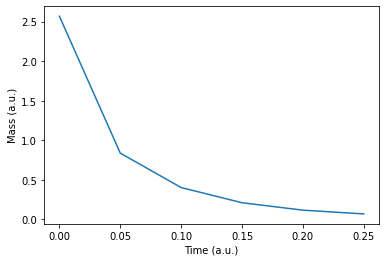

In [ ]:
spantime=np.linspace(0,dt*num_steps,num_steps+1)
plt.plot(spantime,spanmass)
plt.ylabel('Mass (a.u.)')
plt.xlabel('Time (a.u.)')

# V/ Simulation of the Gadobustrol experiments

Now the objective (exercice) is to apply the previous computing framework (solving the time dependant diffusion equation) in order to interpret the clinical data presented in section I/. You will need to adapt the previous code in order to set up relevent mesh, diffusion coefficient, source term and boundary conditions.

Here are some hints :

- Typical volume of a human brain is 1200 cm3.
- Gadobustrol apparent diffusion coefficient :  10−5 - 10−4 cm2/s


## Enrichment phase

Assuming the concentration is 1 (arbitrary unit) in the subarachnoid space after injection. What is the profile of concentration in the brain after 3 hours ?


## Clearance phase

From the previous concentration profile, we would like to compute the clearance. 

The clearance of Gadobustrol is done through the cerebrospinal fluid transport and absorption out of the central nervous system (into the veins or the lynphatic vessels). 

To keep it simple, we can assume that any tracer that reachs the ventricles is flushed out of the system. We can then impose a Dirichlet $c=0$ condition on the ventricles boundary.

We can also assume that during the clearance phase the concentration of tracer in the subarachnoid space is close to the concentration at the surface of the brain. Then no flow of concentration can be assumed on the outer boundary of the brain.

Can you simulate the clearance phase ? 

How does the diffusion coefficient impact this clearance ? Can we make the assumption that this coefficient is different during sleep and awake phases ?


Note : We recomand to work in the CGS unit system (cm, gram, second)